# ***Instantiating a small convnet***

In [0]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

A convnet takes as input tensors of shape **(image_height, image_width, image_channels)** (not including the batch dimension).

In this case, we’ll configure the convnet to process inputs of size (28, 28, 1), which is the format of MNIST images. 

We’ll do this by passing the argument input_shape=(28, 28, 1) to the first layer.

**Let’s display the architecture of the convnet so far:**

In [0]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


You can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). 

The width and height dimensions tend to shrink as you go deeper in the network. 

The number of channels is controlled by the first argument passed to the Conv2D layers (32 or 64).

The next step is to feed the last output tensor (of shape (3, 3, 64)) into a densely connected classifier network like those you’re already familiar with: a stack of Dense layers. 

These classifiers process vectors, which are 1D, whereas the current output is a 3D tensor. First we have to flatten the 3D outputs to 1D, and then add a few Dense layers on top.

# **Adding a classifier on top of the convnet**

In [0]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

We’ll do 10-way classification, using a final layer with 10 outputs and a softmax activation.

Here’s what the network looks like now:

In [0]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_4 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)               

As you can see, the (3, 3, 64) outputs are flattened into vectors of shape (576,) before going through two Dense layers.

Now, let’s train the convnet on the MNIST digits.

# **Training the convnet on MNIST images**

In [0]:
from keras.datasets import mnist
from keras.utils import to_categorical
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [0]:
train_images.shape

(60000, 28, 28)

In [0]:
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255


In [0]:
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model.fit(train_images, train_labels, epochs=3, batch_size=128)

Epoch 1/3
60000/60000 [==============================] - 3s 57us/step - loss: 0.2464 - acc: 0.9233
Epoch 2/3
60000/60000 [==============================] - 3s 50us/step - loss: 0.0534 - acc: 0.9836
Epoch 3/3
60000/60000 [==============================] - 3s 50us/step - loss: 0.0357 - acc: 0.9888


In [0]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
test_acc

0.99

In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [0]:
datagen = ImageDataGenerator(
        horizontal_flip=False, 
        vertical_flip=False)  

datagen.fit(train_images)

In [0]:
batch_size=512
epochs=5

In [0]:
history = model.fit_generator(datagen.flow(train_images, train_labels, batch_size=batch_size),
                              epochs = epochs, validation_data = (test_images, test_labels), steps_per_epoch=train_images.shape[0] // batch_size)

Epoch 1/5
118/118 [==============================] - 2s 16ms/step - loss: 0.0096 - acc: 0.9972 - val_loss: 0.0251 - val_acc: 0.9927
Epoch 2/5
118/118 [==============================] - 2s 16ms/step - loss: 0.0077 - acc: 0.9976 - val_loss: 0.0269 - val_acc: 0.9922
Epoch 3/5
118/118 [==============================] - 2s 15ms/step - loss: 0.0064 - acc: 0.9978 - val_loss: 0.0298 - val_acc: 0.9928
Epoch 4/5
118/118 [==============================] - 2s 15ms/step - loss: 0.0049 - acc: 0.9985 - val_loss: 0.0246 - val_acc: 0.9933
Epoch 5/5
118/118 [==============================] - 2s 16ms/step - loss: 0.0042 - acc: 0.9988 - val_loss: 0.0313 - val_acc: 0.9919


In [0]:
import matplotlib.pyplot as plt
import numpy as np

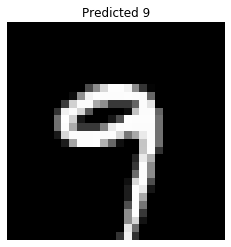

In [0]:
ind = np.random.randint(len(test_images))
pred = model.predict(np.expand_dims(test_images[ind],0))
plt.imshow((test_images[ind].squeeze()*255).astype(np.uint8),cmap='gray')
plt.axis('off')
plt.title('Predicted {}'.format(np.argmax(pred,axis=1)[0]))
plt.show()